In [1]:
# Import the necessary libraries.
# Since we are using Python, import the SparkSession and related functions
# from the PySpark module.
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

In [3]:
# Build a SparkSession using the SparkSession APIs.
# If one does not exist, then create an instance. There
# can only be one SparkSession per JVM.
spark = (SparkSession
.builder
.appName("DataFrame")
.getOrCreate())

In [4]:
sc = spark.sparkContext

##### we want to aggregate all the ages for each name, group by 
###### name, and then average the ages

#### Using RDD

In [5]:
# In Python
# Create an RDD of tuples (name, age)
dataRDD = sc.parallelize([("Brooke", 20), ("Denny", 31), ("Jules", 30),
("TD", 35), ("Brooke", 25),("Jules", 40), ("Denny", 51)])

In [6]:
dataRDD.first()

('Brooke', 20)

In [7]:
dataRDD.take(2)

[('Brooke', 20), ('Denny', 31)]

In [8]:
# Use map and reduceByKey transformations with their lambda
# expressions to aggregate and then compute average

In [10]:
#Step 1
s1 = dataRDD.map(lambda x : (x[0],(x[1],1)))
s1.take(2)

[('Brooke', (20, 1)), ('Denny', (31, 1))]

In [12]:
#Step 2
s2 = s1.reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1]))
s2.take(2)

[('Brooke', (45, 2)), ('Denny', (82, 2))]

In [13]:
s2.collect()

[('Brooke', (45, 2)), ('Denny', (82, 2)), ('Jules', (70, 2)), ('TD', (35, 1))]

In [14]:
#Step 3
s3 = s2.map(lambda x : (x[0],x[1][0]/x[1][1]))

In [15]:
s3.collect()

[('Brooke', 22.5), ('Denny', 41.0), ('Jules', 35.0), ('TD', 35.0)]

In [16]:
agesRDD = (dataRDD
.map(lambda x: (x[0], (x[1], 1)))
.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
.map(lambda x: (x[0], x[1][0]/x[1][1])))

In [17]:
agesRDD.collect()

[('Brooke', 22.5), ('Denny', 41.0), ('Jules', 35.0), ('TD', 35.0)]

#### Using DataFrame

In [6]:
from pyspark.sql.functions import avg

In [19]:
# Create a DataFrame
data_df = spark.createDataFrame([("Brooke", 20), ("Denny", 31), ("Jules", 30),
("TD", 35), ("Brooke", 25),("Jules", 40), ("Denny", 51)],['name','age'])

In [20]:
data_df

DataFrame[name: string, age: bigint]

In [21]:
data_df.show()

+------+---+
|  name|age|
+------+---+
|Brooke| 20|
| Denny| 31|
| Jules| 30|
|    TD| 35|
|Brooke| 25|
| Jules| 40|
| Denny| 51|
+------+---+



In [22]:
data_df.collect()

[Row(name='Brooke', age=20),
 Row(name='Denny', age=31),
 Row(name='Jules', age=30),
 Row(name='TD', age=35),
 Row(name='Brooke', age=25),
 Row(name='Jules', age=40),
 Row(name='Denny', age=51)]

In [23]:
df = data_df.collect()

In [24]:
df[0]

Row(name='Brooke', age=20)

In [27]:
df[0][1]

20

In [29]:
df[0].name

'Brooke'

In [30]:
df[0].age

20

In [31]:
# Group the same names together, aggregate their ages, and compute an average
avg_df = data_df.groupBy('name').agg(avg('age'))

In [32]:
avg_df

DataFrame[name: string, avg(age): double]

In [33]:
avg_df.show()

+------+--------+
|  name|avg(age)|
+------+--------+
|Brooke|    22.5|
| Jules|    35.0|
| Denny|    41.0|
|    TD|    35.0|
+------+--------+



In [36]:
avg_df = data_df.groupBy('name').agg(avg('age').alias('Average'))

In [37]:
avg_df.show()

+------+-------+
|  name|Average|
+------+-------+
|Brooke|   22.5|
| Jules|   35.0|
| Denny|   41.0|
|    TD|   35.0|
+------+-------+



## Creating DataFrames

In [39]:
# spark is an existing SparkSession
df = spark.read.json("people.json")
# Displays the content of the DataFrame to stdout
df.show()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



In [44]:
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



## DataFrame Operations

In Python, it’s possible to access a DataFrame’s columns either by attribute <b>(df.age)</b> or by indexing <b>(df['age'])</b>. While the former is convenient for interactive data exploration, users are highly encouraged to use the latter form, which is future proof and won’t break with column names that are also attributes on the DataFrame class.

In [45]:
from pyspark.sql.functions import col

In [46]:
df.age

Column<'age'>

In [47]:
df['age']

Column<'age'>

In [48]:
col('age')

Column<'age'>

In [50]:
# can cause error if you generate wrong column name
col('adssdd')

Column<'adssdd'>

In [51]:
# spark, df are from the previous example
# Print the schema in a tree format
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



In [52]:
# Select only the "name" column
df.select('name').show()

+-------+
|   name|
+-------+
|Michael|
|   Andy|
| Justin|
+-------+



In [54]:
# Select everybody, but increment the age by 1
df.select(df['name'],df['age'] + 1).show()

+-------+---------+
|   name|(age + 1)|
+-------+---------+
|Michael|     null|
|   Andy|       31|
| Justin|       20|
+-------+---------+



In [64]:
df.select(df['name'],(df['age'] + 1).alias('New Age')).show()

+-------+-------+
|   name|New Age|
+-------+-------+
|Michael|   null|
|   Andy|     31|
| Justin|     20|
+-------+-------+



In [65]:
df.filter(df['age']>21).show()

+---+----+
|age|name|
+---+----+
| 30|Andy|
+---+----+



In [67]:
# Count people by age
df.groupBy('name').count().show()

+-------+-----+
|   name|count|
+-------+-----+
|Michael|    1|
|   Andy|    1|
| Justin|    1|
+-------+-----+



In [69]:
df.groupBy('name').avg().show()

+-------+--------+
|   name|avg(age)|
+-------+--------+
|Michael|    null|
|   Andy|    30.0|
| Justin|    19.0|
+-------+--------+



In [80]:
df.groupBy('name').agg(avg('age').alias('Average')).show()

+-------+-------+
|   name|Average|
+-------+-------+
|Michael|   null|
|   Andy|   30.0|
| Justin|   19.0|
+-------+-------+



## Grouping Data

PySpark DataFrame also provides a way of handling grouped data by using the common approach, split-apply-combine strategy.
It groups the data by a certain condition applies a function to each group and then combines them back to the DataFrame.

In [4]:
df = spark.createDataFrame([
    ['red', 'banana', 1, 10], ['blue', 'banana', 2, 20], ['red', 'carrot', 3, 30],
    ['blue', 'grape', 4, 40], ['red', 'carrot', 5, 50], ['black', 'carrot', 6, 60],
    ['red', 'banana', 7, 70], ['red', 'grape', 8, 80]], schema=['color', 'fruit', 'v1', 'v2'])
df.show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
|  red|banana|  1| 10|
| blue|banana|  2| 20|
|  red|carrot|  3| 30|
| blue| grape|  4| 40|
|  red|carrot|  5| 50|
|black|carrot|  6| 60|
|  red|banana|  7| 70|
|  red| grape|  8| 80|
+-----+------+---+---+



In [84]:
df.groupBy('color')

In [85]:
df.groupBy('color').show()

AttributeError: 'GroupedData' object has no attribute 'show'

In [86]:
df.groupBy('color').avg()

DataFrame[color: string, avg(v1): double, avg(v2): double]

In [87]:
df.groupBy('color').avg().show()

+-----+-------+-------+
|color|avg(v1)|avg(v2)|
+-----+-------+-------+
|  red|    4.8|   48.0|
| blue|    3.0|   30.0|
|black|    6.0|   60.0|
+-----+-------+-------+



In [89]:
df.groupBy('color').avg('v1').show()

+-----+-------+
|color|avg(v1)|
+-----+-------+
|  red|    4.8|
| blue|    3.0|
|black|    6.0|
+-----+-------+



In [90]:
df.groupBy('color').avg('v1','v2').show()

+-----+-------+-------+
|color|avg(v1)|avg(v2)|
+-----+-------+-------+
|  red|    4.8|   48.0|
| blue|    3.0|   30.0|
|black|    6.0|   60.0|
+-----+-------+-------+



In [7]:
from pyspark.sql.functions import avg

In [8]:
df.groupBy('color').agg(avg('v1'),avg('v2')).show()

+-----+-------+-------+
|color|avg(v1)|avg(v2)|
+-----+-------+-------+
|  red|    4.8|   48.0|
| blue|    3.0|   30.0|
|black|    6.0|   60.0|
+-----+-------+-------+



In [9]:
df.groupBy('color').agg(avg('v1').alias('Average v1'),avg('v2').alias('Average v2')).show()

+-----+----------+----------+
|color|Average v1|Average v2|
+-----+----------+----------+
|  red|       4.8|      48.0|
| blue|       3.0|      30.0|
|black|       6.0|      60.0|
+-----+----------+----------+



In [12]:
df.groupBy('color').agg(avg('v1').alias('Average v1'),
                        avg('v2').alias('Average v2')).sort('Average v1').show()

+-----+----------+----------+
|color|Average v1|Average v2|
+-----+----------+----------+
| blue|       3.0|      30.0|
|  red|       4.8|      48.0|
|black|       6.0|      60.0|
+-----+----------+----------+



In [16]:
df.groupBy('color').agg(avg('v1').alias('Average v1'),
                        avg('v2').alias('Average v2')).sort('color').show()

+-----+----------+----------+
|color|Average v1|Average v2|
+-----+----------+----------+
|black|       6.0|      60.0|
| blue|       3.0|      30.0|
|  red|       4.8|      48.0|
+-----+----------+----------+



In [15]:
df.groupBy('color').agg(avg('v1').alias('Average v1'),
                        avg('v2').alias('Average v2')).sort('Average v1','Average v2').show()

+-----+----------+----------+
|color|Average v1|Average v2|
+-----+----------+----------+
| blue|       3.0|      30.0|
|  red|       4.8|      48.0|
|black|       6.0|      60.0|
+-----+----------+----------+



In [17]:
df.show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
|  red|banana|  1| 10|
| blue|banana|  2| 20|
|  red|carrot|  3| 30|
| blue| grape|  4| 40|
|  red|carrot|  5| 50|
|black|carrot|  6| 60|
|  red|banana|  7| 70|
|  red| grape|  8| 80|
+-----+------+---+---+



In [19]:
df.sort('fruit').show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
| blue|banana|  2| 20|
|  red|banana|  1| 10|
|  red|banana|  7| 70|
|  red|carrot|  5| 50|
|  red|carrot|  3| 30|
|black|carrot|  6| 60|
| blue| grape|  4| 40|
|  red| grape|  8| 80|
+-----+------+---+---+



In [20]:
df.sort('fruit','v1').show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
|  red|banana|  1| 10|
| blue|banana|  2| 20|
|  red|banana|  7| 70|
|  red|carrot|  3| 30|
|  red|carrot|  5| 50|
|black|carrot|  6| 60|
| blue| grape|  4| 40|
|  red| grape|  8| 80|
+-----+------+---+---+



In [21]:
df.sort('color','fruit','v1').show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
|black|carrot|  6| 60|
| blue|banana|  2| 20|
| blue| grape|  4| 40|
|  red|banana|  1| 10|
|  red|banana|  7| 70|
|  red|carrot|  3| 30|
|  red|carrot|  5| 50|
|  red| grape|  8| 80|
+-----+------+---+---+



In [22]:
df.groupby('color').count().show()

+-----+-----+
|color|count|
+-----+-----+
|  red|    5|
| blue|    2|
|black|    1|
+-----+-----+



In [23]:
df.groupby(['color','fruit']).avg().show()

+-----+------+-------+-------+
|color| fruit|avg(v1)|avg(v2)|
+-----+------+-------+-------+
| blue| grape|    4.0|   40.0|
|  red|banana|    4.0|   40.0|
|  red|carrot|    4.0|   40.0|
| blue|banana|    2.0|   20.0|
|black|carrot|    6.0|   60.0|
|  red| grape|    8.0|   80.0|
+-----+------+-------+-------+



In [24]:
df.groupby('color').count().show()

+-----+-----+
|color|count|
+-----+-----+
|  red|    5|
| blue|    2|
|black|    1|
+-----+-----+



In [25]:
df.groupby(['color','fruit']).avg('v1').show()
df.groupby('color').avg('v2').show()

+-----+------+-------+
|color| fruit|avg(v1)|
+-----+------+-------+
| blue| grape|    4.0|
|  red|banana|    4.0|
|  red|carrot|    4.0|
| blue|banana|    2.0|
|black|carrot|    6.0|
|  red| grape|    8.0|
+-----+------+-------+

+-----+-------+
|color|avg(v2)|
+-----+-------+
|  red|   48.0|
| blue|   30.0|
|black|   60.0|
+-----+-------+



In [26]:
df.groupby(['color','fruit']).agg(avg('v1').alias('v1_avg')).show()
df.groupby('color').agg(avg('v2').alias('v2_avg')).show()

+-----+------+------+
|color| fruit|v1_avg|
+-----+------+------+
| blue| grape|   4.0|
|  red|banana|   4.0|
|  red|carrot|   4.0|
| blue|banana|   2.0|
|black|carrot|   6.0|
|  red| grape|   8.0|
+-----+------+------+

+-----+------+
|color|v2_avg|
+-----+------+
|  red|  48.0|
| blue|  30.0|
|black|  60.0|
+-----+------+



## Schemas and Creating DataFrames

### Two ways to define a schema
Spark allows you to define a schema in two ways. <b>One is to define it programmatically</b>,
and the other is to <b>employ a Data Definition Language (DDL) string</b>, which is
much simpler and easier to read.

<b>To define a schema programmatically for a DataFrame with three named columns,
author, title, and pages, you can use the Spark DataFrame API. <i>For example:</i></b>

In [27]:
from pyspark.sql.types import *

In [28]:
schema = StructType([StructField('author',StringType(),False),
                    StructField("title", StringType(), False),
                    StructField("pages", IntegerType(), False)])

<b>Defining the same schema using DDL is much simpler:</b>

In [29]:
# Define schema for our data using DDL
# we are using back quote (`Id`) to define column name
schema = "`Id` INT, `First` STRING, `Last` STRING, `Url` STRING,`Published` STRING, `Hits` INT, `Campaigns` ARRAY<STRING>"

In [30]:
data = [[1, "Jules", "Damji", "https://tinyurl.1", "1/4/2016", 4535, ["twitter","LinkedIn"]],
[2, "Brooke","Wenig", "https://tinyurl.2", "5/5/2018", 8908, ["twitter","LinkedIn"]],
[3, "Denny", "Lee", "https://tinyurl.3", "6/7/2019", 7659, ["web","twitter", "FB", "LinkedIn"]],
[4, "Tathagata", "Das", "https://tinyurl.4", "5/12/2018", 10568,["twitter", "FB"]],
[5, "Matei","Zaharia", "https://tinyurl.5", "5/14/2014", 40578, ["web","twitter", "FB", "LinkedIn"]],
[6, "Reynold", "Xin", "https://tinyurl.6", "3/2/2015", 25568,["twitter", "LinkedIn"]]]

In [32]:
# Written blogs by authors and advertised on social media.

# Create a DataFrame using the schema defined above
blogs_df = spark.createDataFrame(data, schema)
# Show the DataFrame; it should reflect our table above
blogs_df.show()
# Print the schema used by Spark to process the DataFrame
print(blogs_df.printSchema())

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+

root
 |-- Id: integer (nullable = true)
 |-- First: string (nullable = true)
 |-- Last: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Published: string (nullable = true)
 |-- Hits: integer (

In [33]:
# Create a DataFrame without using the schema 
blogs_df_2 = spark.createDataFrame(data)
# Show the DataFrame; it should reflect our table above
blogs_df_2.show()
# Print the schema used by Spark to process the DataFrame
print(blogs_df_2.printSchema())

+---+---------+-------+-----------------+---------+-----+--------------------+
| _1|       _2|     _3|               _4|       _5|   _6|                  _7|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+

root
 |-- _1: long (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: string (nullable = true)
 |-- _4: string (nullable = true)
 |-- _5: string (nullable = true)
 |-- _6: long (nullable = true)
 |--

In [34]:
# Create a DataFrame without using the schema 
blogs_df_3 = spark.createDataFrame(data,['Id', 'First', 'Last', 'Url','Published', 'Hits', 'Campaigns'])
# Show the DataFrame; it should reflect our table above
blogs_df_3.show()
# Print the schema used by Spark to process the DataFrame
print(blogs_df_3.printSchema())

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+

root
 |-- Id: long (nullable = true)
 |-- First: string (nullable = true)
 |-- Last: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Published: string (nullable = true)
 |-- Hits: long (nullab

In [35]:
# We can get the schema definition and use it anywhere
blogs_df.schema

StructType(List(StructField(Id,IntegerType,true),StructField(First,StringType,true),StructField(Last,StringType,true),StructField(Url,StringType,true),StructField(Published,StringType,true),StructField(Hits,IntegerType,true),StructField(Campaigns,ArrayType(StringType,true),true)))

In [36]:
blogs_df.columns

['Id', 'First', 'Last', 'Url', 'Published', 'Hits', 'Campaigns']

In [37]:
blogs_df['Hits']

Column<'Hits'>

In [38]:
blogs_df.select('Hits').show()

+-----+
| Hits|
+-----+
| 4535|
| 8908|
| 7659|
|10568|
|40578|
|25568|
+-----+



In [39]:
blogs_df.select('Hits').show(3)

+----+
|Hits|
+----+
|4535|
|8908|
|7659|
+----+
only showing top 3 rows



In [41]:
blogs_df.select('Hits').head(3)

[Row(Hits=4535), Row(Hits=8908), Row(Hits=7659)]

In [43]:
blogs_df.select(blogs_df['Hits']*2).show()

+----------+
|(Hits * 2)|
+----------+
|      9070|
|     17816|
|     15318|
|     21136|
|     81156|
|     51136|
+----------+



In [52]:
blogs_df.select((blogs_df['Hits']*2).alias('Double Hits')).show()

+-----------+
|Double Hits|
+-----------+
|       9070|
|      17816|
|      15318|
|      21136|
|      81156|
|      51136|
+-----------+



In [45]:
from pyspark.sql.functions import expr

In [46]:
blogs_df.select(expr('Hits * 2')).show()

+----------+
|(Hits * 2)|
+----------+
|      9070|
|     17816|
|     15318|
|     21136|
|     81156|
|     51136|
+----------+



In [53]:
blogs_df.select(expr('Hits * 2').alias('Double Hits')).show()

+-----------+
|Double Hits|
+-----------+
|       9070|
|      17816|
|      15318|
|      21136|
|      81156|
|      51136|
+-----------+



In [54]:
blogs_df.select('Hits',expr('Hits * 2').alias('Double Hits')).show()

+-----+-----------+
| Hits|Double Hits|
+-----+-----------+
| 4535|       9070|
| 8908|      17816|
| 7659|      15318|
|10568|      21136|
|40578|      81156|
|25568|      51136|
+-----+-----------+



In [59]:
blogs_df.select('Hits * 2')

AnalysisException: cannot resolve '`Hits * 2`' given input columns: [Campaigns, First, Hits, Id, Last, Published, Url];
'Project ['Hits * 2]
+- LogicalRDD [Id#620, First#621, Last#622, Url#623, Published#624, Hits#625, Campaigns#626], false


In [61]:
blogs_df.select('Hits').show()

+-----+
| Hits|
+-----+
| 4535|
| 8908|
| 7659|
|10568|
|40578|
|25568|
+-----+



In [62]:
blogs_df.select('Hits','First').show()

+-----+---------+
| Hits|    First|
+-----+---------+
| 4535|    Jules|
| 8908|   Brooke|
| 7659|    Denny|
|10568|Tathagata|
|40578|    Matei|
|25568|  Reynold|
+-----+---------+



In [64]:
from pyspark.sql.functions import col

In [65]:
blogs_df.select((col("Hits") * 2)).show()

+----------+
|(Hits * 2)|
+----------+
|      9070|
|     17816|
|     15318|
|     21136|
|     81156|
|     51136|
+----------+



In [66]:
blogs_df.select((col("Hits") * 2).alias('Double Hits')).show()

+-----------+
|Double Hits|
+-----------+
|       9070|
|      17816|
|      15318|
|      21136|
|      81156|
|      51136|
+-----------+



In [67]:
# Creating New Column
blogs_df.withColumn('Big Hitters',col('Hits')>10000).show()

+---+---------+-------+-----------------+---------+-----+--------------------+-----------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|Big Hitters|
+---+---------+-------+-----------------+---------+-----+--------------------+-----------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|      false|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|      false|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|      false|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|       true|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|       true|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|       true|
+---+---------+-------+-----------------+---------+-----+--------------------+-----------+



In [71]:
from pyspark.sql.functions import concat

In [73]:
blogs_df_fullName = blogs_df.withColumn("Full Name",concat(col('First'),col('Last')))

In [74]:
blogs_df_fullName

DataFrame[Id: int, First: string, Last: string, Url: string, Published: string, Hits: int, Campaigns: array<string>, Full Name: string]

In [75]:
blogs_df_fullName.show()

+---+---------+-------+-----------------+---------+-----+--------------------+------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|   Full Name|
+---+---------+-------+-----------------+---------+-----+--------------------+------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|  JulesDamji|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]| BrookeWenig|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|    DennyLee|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|TathagataDas|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|MateiZaharia|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|  ReynoldXin|
+---+---------+-------+-----------------+---------+-----+--------------------+------------+



In [76]:
blogs_df_fullName.show(2)

+---+------+-----+-----------------+---------+----+-------------------+-----------+
| Id| First| Last|              Url|Published|Hits|          Campaigns|  Full Name|
+---+------+-----+-----------------+---------+----+-------------------+-----------+
|  1| Jules|Damji|https://tinyurl.1| 1/4/2016|4535|[twitter, LinkedIn]| JulesDamji|
|  2|Brooke|Wenig|https://tinyurl.2| 5/5/2018|8908|[twitter, LinkedIn]|BrookeWenig|
+---+------+-----+-----------------+---------+----+-------------------+-----------+
only showing top 2 rows



In [78]:
blogs_df_fullName.select('Full Name').show()

+------------+
|   Full Name|
+------------+
|  JulesDamji|
| BrookeWenig|
|    DennyLee|
|TathagataDas|
|MateiZaharia|
|  ReynoldXin|
+------------+



In [82]:
# You do not have to get all data frame if you need only the full name
df_fullName = blogs_df.withColumn("Full Name",concat(col('First'),col('Last'))).select('Full Name')

In [83]:
df_fullName.show()

+------------+
|   Full Name|
+------------+
|  JulesDamji|
| BrookeWenig|
|    DennyLee|
|TathagataDas|
|MateiZaharia|
|  ReynoldXin|
+------------+



In [86]:
blogs_df.sort('ID').show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [88]:
blogs_df.sort('ID','First').show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [93]:
blogs_df.sort(blogs_df['ID'].desc()).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [96]:
blogs_df.sort(blogs_df.Id.desc()).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [95]:
blogs_df.sort(blogs_df['ID'], ascending=False).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [94]:
blogs_df.sort(col('ID').desc()).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [92]:
blogs_df.sort(col('ID'),ascending=False).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



In [97]:
blogs_df.sort(['ID','First'],ascending=False).show()

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+



# Dealing with missing data with pyspark


## Missing Data
1. Keep them.
2. Remove them.
3. Fill them with some values.

In [104]:
df = spark.read.csv('NullData.csv',header=True,inferSchema=True)

In [105]:
df.show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [107]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sales: double (nullable = true)



In [100]:
df = spark.read.csv('NullData.csv')

In [101]:
df.show()

+----+-----+-----+
| _c0|  _c1|  _c2|
+----+-----+-----+
|  Id| Name|Sales|
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [103]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)



In [108]:
df.show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [109]:
df.na.drop().show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp4|Cindy|456.0|
+----+-----+-----+



In [111]:
df.show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [110]:
# If specified, drop rows that have less than `thresh` non-null values.
# This overwrites the `how` parameter.
df.na.drop(thresh=2).show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp1| John| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [112]:
df.na.drop(thresh=1).show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp1| John| null|
|emp2| null| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [113]:
df.na.drop(thresh=3).show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp4|Cindy|456.0|
+----+-----+-----+



In [114]:
df.na.drop(subset=['Sales']).show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [119]:
df.na.drop(subset=['Sales','Name']).show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp4|Cindy|456.0|
+----+-----+-----+



In [120]:
df.na.drop(thresh=1,subset=['Sales','Name']).show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp1| John| null|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [121]:
df.na.drop(thresh=2,subset=['Sales','Name']).show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp4|Cindy|456.0|
+----+-----+-----+



In [122]:
df.na.fill('Fill Value').show()

+----+----------+-----+
|  Id|      Name|Sales|
+----+----------+-----+
|emp1|      John| null|
|emp2|Fill Value| null|
|emp3|Fill Value|345.0|
|emp4|     Cindy|456.0|
+----+----------+-----+



In [123]:
df.na.fill(0).show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp1| John|  0.0|
|emp2| null|  0.0|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



In [124]:
df.na.fill('No Name',subset=['Name']).show()

+----+-------+-----+
|  Id|   Name|Sales|
+----+-------+-----+
|emp1|   John| null|
|emp2|No Name| null|
|emp3|No Name|345.0|
|emp4|  Cindy|456.0|
+----+-------+-----+



In [125]:
from pyspark.sql.functions import mean

In [128]:
mean_val = df.select(mean(df['Sales']).alias('mean')).collect()

In [133]:
mean_val[0].mean

400.5

In [134]:
mean_sales = mean_val[0].mean

In [135]:
df.na.fill(mean_sales,subset=['sales']).show()

+----+-----+-----+
|  Id| Name|Sales|
+----+-----+-----+
|emp1| John|400.5|
|emp2| null|400.5|
|emp3| null|345.0|
|emp4|Cindy|456.0|
+----+-----+-----+



### How to deal with null complete example

In [136]:
df= spark.read.csv('MELBOURNE_HOUSE_PRICES_LESS.csv',header = True,inferSchema=True)

In [137]:
df.printSchema()

root
 |-- Suburb: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Method: string (nullable = true)
 |-- SellerG: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Postcode: integer (nullable = true)
 |-- Regionname: string (nullable = true)
 |-- Propertycount: integer (nullable = true)
 |-- Distance: double (nullable = true)
 |-- CouncilArea: string (nullable = true)



In [138]:
df.count()

63023

In [139]:
df.show(5,truncate=False)

+------------+----------------+-----+----+-------+------+--------+---------+--------+---------------------+-------------+--------+--------------------------+
|Suburb      |Address         |Rooms|Type|Price  |Method|SellerG |Date     |Postcode|Regionname           |Propertycount|Distance|CouncilArea               |
+------------+----------------+-----+----+-------+------+--------+---------+--------+---------------------+-------------+--------+--------------------------+
|Abbotsford  |49 Lithgow St   |3    |h   |1490000|S     |Jellis  |1/04/2017|3067    |Northern Metropolitan|4019         |3.0     |Yarra City Council        |
|Abbotsford  |59A Turner St   |3    |h   |1220000|S     |Marshall|1/04/2017|3067    |Northern Metropolitan|4019         |3.0     |Yarra City Council        |
|Abbotsford  |119B Yarra St   |3    |h   |1420000|S     |Nelson  |1/04/2017|3067    |Northern Metropolitan|4019         |3.0     |Yarra City Council        |
|Aberfeldie  |68 Vida St      |3    |h   |1515000|S 

In [140]:
df.take(2)

[Row(Suburb='Abbotsford', Address='49 Lithgow St', Rooms=3, Type='h', Price=1490000, Method='S', SellerG='Jellis', Date='1/04/2017', Postcode=3067, Regionname='Northern Metropolitan', Propertycount=4019, Distance=3.0, CouncilArea='Yarra City Council'),
 Row(Suburb='Abbotsford', Address='59A Turner St', Rooms=3, Type='h', Price=1220000, Method='S', SellerG='Marshall', Date='1/04/2017', Postcode=3067, Regionname='Northern Metropolitan', Propertycount=4019, Distance=3.0, CouncilArea='Yarra City Council')]

In [141]:
df.head(2)

[Row(Suburb='Abbotsford', Address='49 Lithgow St', Rooms=3, Type='h', Price=1490000, Method='S', SellerG='Jellis', Date='1/04/2017', Postcode=3067, Regionname='Northern Metropolitan', Propertycount=4019, Distance=3.0, CouncilArea='Yarra City Council'),
 Row(Suburb='Abbotsford', Address='59A Turner St', Rooms=3, Type='h', Price=1220000, Method='S', SellerG='Marshall', Date='1/04/2017', Postcode=3067, Regionname='Northern Metropolitan', Propertycount=4019, Distance=3.0, CouncilArea='Yarra City Council')]

In [142]:
df.describe().show()

+-------+----------+-----------+------------------+-----+-----------------+------+-----------+---------+------------------+--------------------+-----------------+------------------+--------------------+
|summary|    Suburb|    Address|             Rooms| Type|            Price|Method|    SellerG|     Date|          Postcode|          Regionname|    Propertycount|          Distance|         CouncilArea|
+-------+----------+-----------+------------------+-----+-----------------+------+-----------+---------+------------------+--------------------+-----------------+------------------+--------------------+
|  count|     63023|      63023|             63023|63023|            48433| 63023|      63023|    63023|             63023|               63023|            63023|             63023|               63023|
|   mean|      null|       null| 3.110594544848706| null|997898.2414882415|  null|       null|     null|3125.6738968313157|                null|7617.728130999793|12.684829348016626|       

In [143]:
df.describe('price').show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|            48433|
|   mean|997898.2414882415|
| stddev|593498.9190372769|
|    min|            85000|
|    max|         11200000|
+-------+-----------------+



In [144]:
df.describe(['price','Rooms']).show()

+-------+-----------------+------------------+
|summary|            price|             Rooms|
+-------+-----------------+------------------+
|  count|            48433|             63023|
|   mean|997898.2414882415| 3.110594544848706|
| stddev|593498.9190372769|0.9575513092737391|
|    min|            85000|                 1|
|    max|         11200000|                31|
+-------+-----------------+------------------+



In [145]:
df.describe(['price','Distance']).show()

+-------+-----------------+------------------+
|summary|            price|          Distance|
+-------+-----------------+------------------+
|  count|            48433|             63023|
|   mean|997898.2414882415|12.684829348016626|
| stddev|593498.9190372769|  7.59201536912572|
|    min|            85000|               0.0|
|    max|         11200000|              64.1|
+-------+-----------------+------------------+



In [146]:
df.describe(df.columns).show()

+-------+----------+-----------+------------------+-----+-----------------+------+-----------+---------+------------------+--------------------+-----------------+------------------+--------------------+
|summary|    Suburb|    Address|             Rooms| Type|            Price|Method|    SellerG|     Date|          Postcode|          Regionname|    Propertycount|          Distance|         CouncilArea|
+-------+----------+-----------+------------------+-----+-----------------+------+-----------+---------+------------------+--------------------+-----------------+------------------+--------------------+
|  count|     63023|      63023|             63023|63023|            48433| 63023|      63023|    63023|             63023|               63023|            63023|             63023|               63023|
|   mean|      null|       null| 3.110594544848706| null|997898.2414882415|  null|       null|     null|3125.6738968313157|                null|7617.728130999793|12.684829348016626|       

In [147]:
df.corr('price','Distance')

-0.16922103499603033

In [148]:
df.cov('price','Distance')

-859770.4567980698

In [150]:
from pyspark.sql.functions import when, count, col, isnull
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+-------+-----+----+-----+------+-------+----+--------+----------+-------------+--------+-----------+
|Suburb|Address|Rooms|Type|Price|Method|SellerG|Date|Postcode|Regionname|Propertycount|Distance|CouncilArea|
+------+-------+-----+----+-----+------+-------+----+--------+----------+-------------+--------+-----------+
|     0|      0|    0|   0|14590|     0|      0|   0|       0|         0|            0|       0|          0|
+------+-------+-----+----+-----+------+-------+----+--------+----------+-------------+--------+-----------+




[Stage 176:============================>                            (1 + 1) / 2]



In [153]:
import missingno as msno

In [154]:
df_pd = df.toPandas()

In [155]:
df_pd.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


<AxesSubplot:>

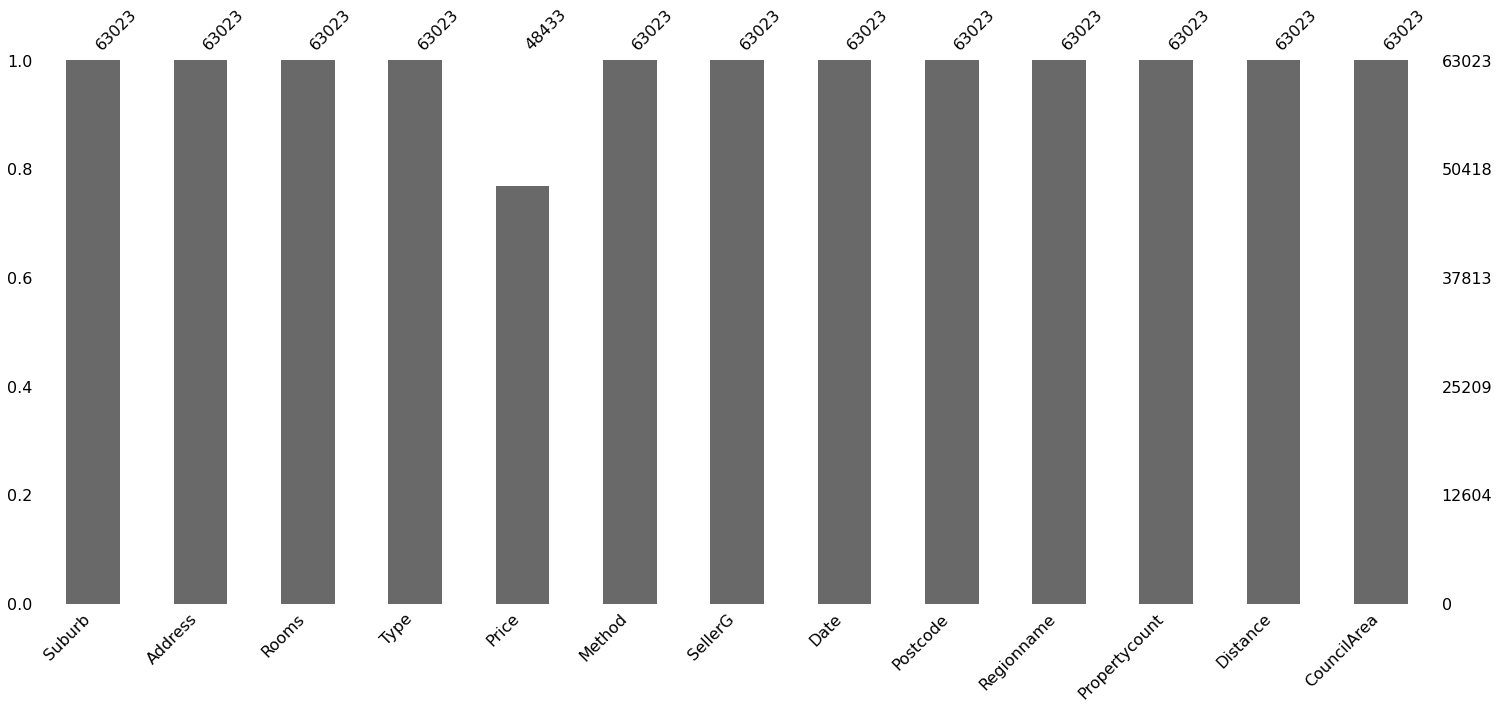

In [156]:
msno.bar(df_pd)


[Stage 180:============================>                            (1 + 1) / 2]



<AxesSubplot:>

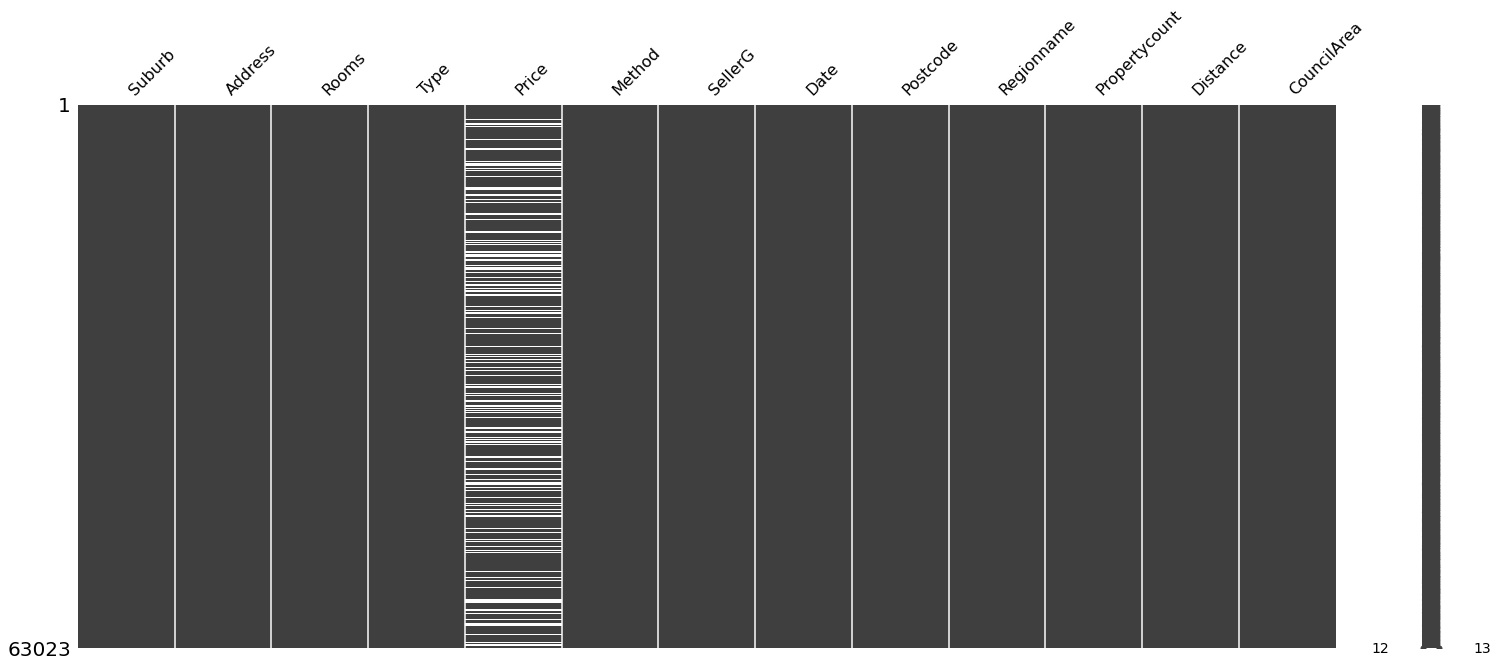

In [157]:
msno.matrix(df.toPandas())

In [158]:
noMissing=df.dropna(how='any',subset=['Price'])

In [159]:
df.count()

63023

In [160]:
noMissing.count()

48433

In [161]:
noMissing.select([count(when(isnull(c), c)).alias(c) for c in noMissing.columns]).show()

+------+-------+-----+----+-----+------+-------+----+--------+----------+-------------+--------+-----------+
|Suburb|Address|Rooms|Type|Price|Method|SellerG|Date|Postcode|Regionname|Propertycount|Distance|CouncilArea|
+------+-------+-----+----+-----+------+-------+----+--------+----------+-------------+--------+-----------+
|     0|      0|    0|   0|    0|     0|      0|   0|       0|         0|            0|       0|          0|
+------+-------+-----+----+-----+------+-------+----+--------+----------+-------------+--------+-----------+



In [162]:
nmsng = noMissing.toPandas()


[Stage 190:============================>                            (1 + 1) / 2]



<AxesSubplot:>

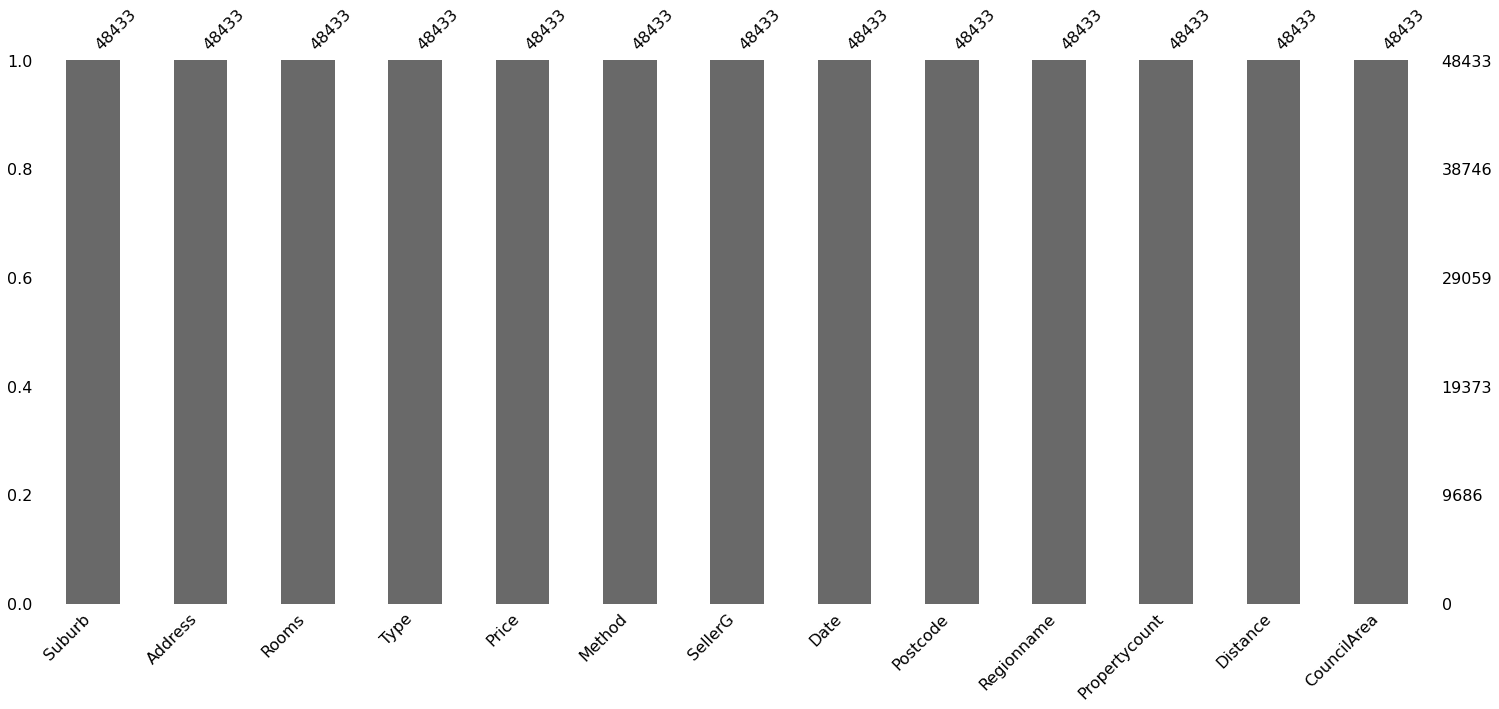

In [163]:
msno.bar(nmsng)

<AxesSubplot:>

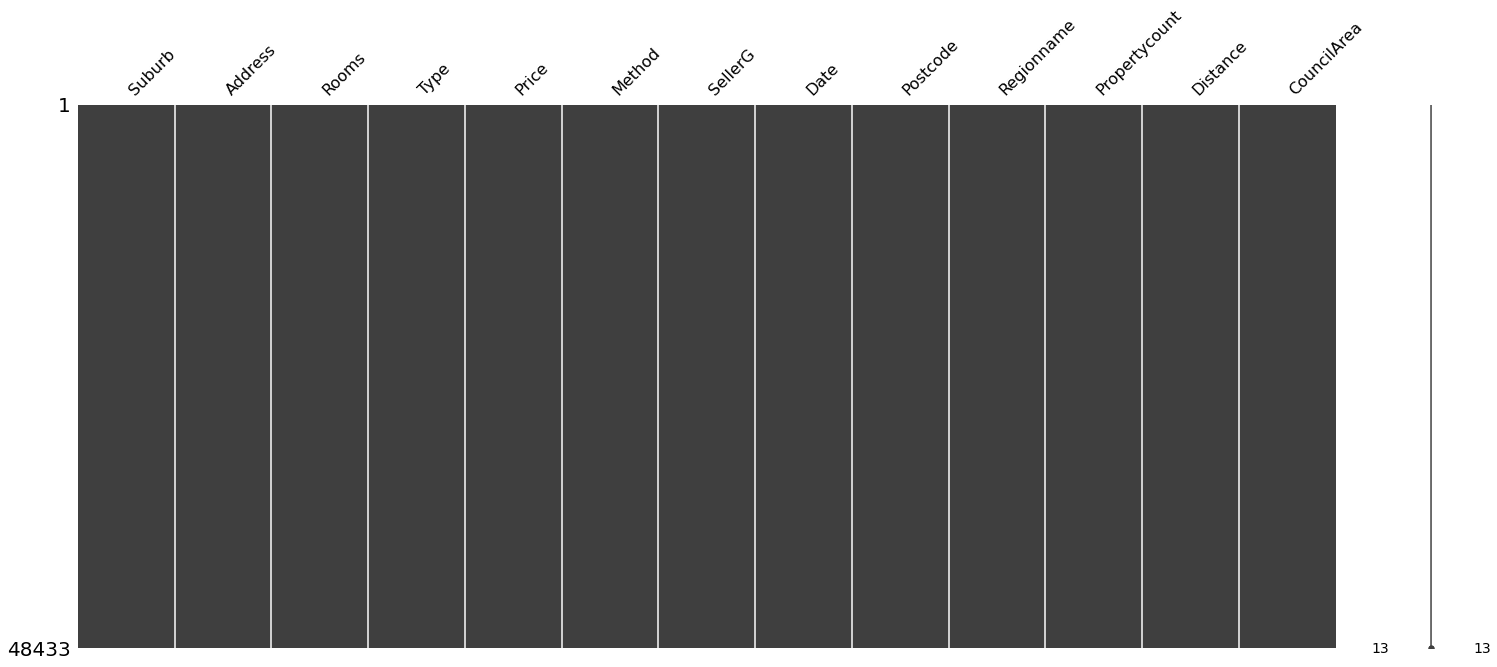

In [164]:
msno.matrix(nmsng)

### DataFrame operations example on MnM data

In [165]:
# Build a SparkSession using the SparkSession APIs.
# If one does not exist, then create an instance. There
# can only be one SparkSession per JVM.
spark = (SparkSession
.builder
.appName("PythonMnMCount")
.config("spark.driver.memory", "9g")
.getOrCreate())

In [167]:
mnm_file='mnm_dataset.csv'
mnm_df = (spark.read.format("csv")
.option("header", "true")
.option("inferSchema", "true")
.load(mnm_file))

In [168]:
# We use the DataFrame high-level APIs. Note
# that we don't use RDDs at all. Because some of Spark's
# functions return the same object, we can chain function calls.
# 1. Select from the DataFrame the fields "State", "Color", and "Count"
# 2. Since we want to group each state and its M&M color count,
# we use groupBy()
# 3. Aggregate counts of all colors and groupBy() State and Color
# 4 orderBy() in descending order
count_mnm_df = (mnm_df
.select("State", "Color", "Count")
.groupBy("State", "Color")
.agg(count("Count").alias("Total"))
.orderBy("Total", ascending=False))
# Show the resulting aggregations for all the states and colors;
# a total count of each color per state.
# Note show() is an action, which will trigger the above
# query to be executed.
count_mnm_df.show(n=60, truncate=False)
print("Total Rows = %d" % (count_mnm_df.count()))

+-----+------+-----+
|State|Color |Total|
+-----+------+-----+
|CA   |Yellow|1807 |
|WA   |Green |1779 |
|OR   |Orange|1743 |
|TX   |Green |1737 |
|TX   |Red   |1725 |
|CA   |Green |1723 |
|CO   |Yellow|1721 |
|CA   |Brown |1718 |
|CO   |Green |1713 |
|NV   |Orange|1712 |
|TX   |Yellow|1703 |
|NV   |Green |1698 |
|AZ   |Brown |1698 |
|WY   |Green |1695 |
|CO   |Blue  |1695 |
|NM   |Red   |1690 |
|AZ   |Orange|1689 |
|NM   |Yellow|1688 |
|NM   |Brown |1687 |
|UT   |Orange|1684 |
|NM   |Green |1682 |
|UT   |Red   |1680 |
|AZ   |Green |1676 |
|NV   |Yellow|1675 |
|NV   |Blue  |1673 |
|WA   |Red   |1671 |
|WY   |Red   |1670 |
|WA   |Brown |1669 |
|NM   |Orange|1665 |
|WY   |Blue  |1664 |
|WA   |Yellow|1663 |
|WA   |Orange|1658 |
|CA   |Orange|1657 |
|NV   |Brown |1657 |
|CA   |Red   |1656 |
|CO   |Brown |1656 |
|UT   |Blue  |1655 |
|AZ   |Yellow|1654 |
|TX   |Orange|1652 |
|AZ   |Red   |1648 |
|OR   |Blue  |1646 |
|UT   |Yellow|1645 |
|OR   |Red   |1645 |
|CO   |Orange|1642 |
|TX   |Brown 

In [169]:
# While the above code aggregated and counted for all
# the states, what if we just want to see the data for
# a single state, e.g., CA?
# 1. Select from all rows in the DataFrame
# 2. Filter only CA state
# 3. groupBy() State and Color as we did above
# 4. Aggregate the counts for each color
# 5. orderBy() in descending order
# Find the aggregate count for California by filtering
ca_count_mnm_df = (mnm_df
.select("State", "Color", "Count")
.where(mnm_df.State == "CA")
.groupBy("State", "Color")
.agg(count("Count").alias("Total"))
.orderBy("Total", ascending=False))
# Show the resulting aggregation for California.
# As above, show() is an action that will trigger the execution of the
# entire computation.
ca_count_mnm_df.show(n=10, truncate=False)
# Stop the SparkSession
spark.stop()

+-----+------+-----+
|State|Color |Total|
+-----+------+-----+
|CA   |Yellow|1807 |
|CA   |Green |1723 |
|CA   |Brown |1718 |
|CA   |Orange|1657 |
|CA   |Red   |1656 |
|CA   |Blue  |1603 |
+-----+------+-----+

